# Object Classification with CNNs

Object classification in images with convolutional neural networks (CNNs) is arguably what ignited the field of deep learning (or re-ignited the field of neural networks). The structural prior given by using convolutions is incredibly powerful when processing images, such that features extracted from a randomly initialised CNN can be pretty useful.

Deep learning with CNNs shine in computer vision tasks with plenty of labelled data, so we'll look at a fairly standard pipeline based on object classification.

## Data

We'll use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which comprises of 60,000 32x32 colour images in 10 classes. The 10 classes contain basic categories of both natural and manmade objects. Here's a selection of some from each class:

![CIFAR-10 samples](https://kaggle2.blob.core.windows.net/competitions/kaggle/3649/media/cifar-10.png)

The dataset is split into 50,000 training images and 10,000 test images, with a uniform distribution of examples per class. We can use a premade dataset loader from the `torchvision` package. We'll also normalise the data using mean and standard deviation statistics pre-calculated from the entire dataset. When loading training data, we'll also apply some (class-preserving) data augmentations in order to make the model more robust to these sorts of transformations. Finally, we'll make use of asynchronous data loading workers to queue up data while the network is training.

In [7]:
import os
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from IPython.display import clear_output, display
%matplotlib inline

In [8]:
batch_size = 128

# Set up a convenient default data path
data_path = os.path.join(os.path.expanduser('~'), '.torch', 'datasets', 'cifar10')
# Set up datasets including normalisation and a data augmentation pipeline for the training data
train_data = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
]))
test_data = datasets.CIFAR10(data_path, train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
]))
# Use asynchronous data loading (loads images in separate workers)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=4)

KeyboardInterrupt: 

## Model

For the model we'll use a fairly standard set of components - (strided) convolutions, batch normalisation, dropout and ELU nonlinearities. This is on the small side and not well-tuned for CIFAR-10, but is just supposed to be representative of a typical CNN (without skip connections, which are commonplace in deeper architectures).

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 7, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, 3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 512, bias=False)
        self.dp1 = nn.Dropout()
        self.bn5 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.elu(self.bn1(self.conv1(x)))
        x = F.elu(self.bn2(self.conv2(x)))
        x = F.elu(self.bn3(self.conv3(x)))
        x = F.elu(self.bn4(self.conv4(x)))
        x = x.view(-1, 64 * 8 * 8)  # Reshape from spatial B x C x H x W into 1D features B x CHW
        x = F.elu(self.bn5(self.dp1(self.fc1(x))))
        return self.fc2(x)

## Training and Testing

We'll instantiate the model here and train it for a few epochs and plot the training loss for each minibatch. At the end of each epoch we'll also include the test loss, calculated over the entire test set. Finally, we'll print the classification accuracy of the trained model on the test set. It's important to use `.train()` and `.eval()` on the model as appropriate, as batch normalisation and dropout should perform differently depending on whether the model is training or is being used for evaluation. During testing, using the `torch.no_grad()` context manager prevents a computation graph being stored (as otherwise, PyTorch would store a graph because the data interacts with parameters that require gradients by default).

Note that to get good performance on this sort of dataset, you would typically want a deeper model running on GPU for many epochs. However, the general components of the architecture, or the training pipeline with data augmentation and normalisation, would remain much the same.

In [4]:
model = Net()
optimiser = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, nesterov=True, weight_decay=1e-4)
train_losses, test_losses, test_acc = [], [], 0
epochs, iters_per_epoch = 3, len(train_loader)

plt.figure(figsize=(14, 8))
plt.xlabel('Iterations')
plt.ylabel('Loss')
plotted_legend = False

def plot():
    global plotted_legend
    plt.plot(range(len(train_losses)), train_losses, 'b-', label='Train')
    plt.plot([(i + 1) * iters_per_epoch - 1 for i in range(len(test_losses))], test_losses, 'r-', label='Test')
    clear_output(wait=True)
    display(plt.gcf())
    if not plotted_legend:
        plt.legend(loc='upper right')
        plotted_legend = True

def train():
    model.train()
    for i, (x, y) in enumerate(train_loader):
        optimiser.zero_grad()
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y)
        loss.backward()
        train_losses.append(loss.item())
        optimiser.step()
        if i % 10 == 0:
            plot()

def test():
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            y_hat = model(x)
            test_loss += F.cross_entropy(y_hat, y, reduction='sum').item()
            pred = y_hat.argmax(1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    test_losses.append(test_loss / len(test_data))
    return correct / len(test_data)

for _ in range(epochs):
    train()
    test_acc = test()
plot()
clear_output(wait=True)
display('Final test accuracy: %.2f%%' % (test_acc * 100))

NameError: name 'train_loader' is not defined

## GPU Acceleration

We can get over 50% accuracy in not too long with a small CNN running on CPU. However, most NNs in use nowadays benefit from the parallelisation afforded by GPUs. We'll make a larger network (with a combination of residual blocks and grouped convolutions that goes by the name of ResNeXt) which would take longer to train on CPU, and run it on GPU. We'll also demonstrate using a learning rate scheduler (with a non-standard schedule), as these are often used when really optimising for performance.

In [5]:
class ResNeXtBlock(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.prelu1 = nn.PReLU(2 * hidden_size)
        self.conv1 = nn.Conv2d(2 * hidden_size, hidden_size, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(hidden_size)
        self.prelu2 = nn.PReLU(hidden_size)
        self.conv2 = nn.Conv2d(hidden_size, hidden_size, 3, padding=1, groups=hidden_size // 4, bias=False)
        self.bn2 = nn.BatchNorm2d(hidden_size)
        self.prelu3 = nn.PReLU(hidden_size)
        self.conv3 = nn.Conv2d(hidden_size, 2 * hidden_size, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(2 * hidden_size)

    def forward(self, x):
        r = self.bn1(self.conv1(self.prelu1(x)))
        r = self.bn2(self.conv2(self.prelu2(r)))
        r = self.bn3(self.conv3(self.prelu3(r)))
        x = r + x
        return x

class ResNeXt(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 7, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.prelu1 = nn.PReLU(32)
        self.res1 = ResNeXtBlock(16)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.prelu2 = nn.PReLU(64)
        self.res2 = ResNeXtBlock(32)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.prelu3 = nn.PReLU(128)
        self.res3 = ResNeXtBlock(64)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(256)
        self.prelu4 = nn.PReLU(256)
        self.fc1 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.prelu1(self.bn1(self.conv1(x)))
        x = self.prelu2(self.bn2(self.conv2(self.res1(x))))
        x = self.prelu3(self.bn3(self.conv3(self.res2(x))))
        x = self.prelu4(self.bn4(self.conv4(self.res3(x))))
        x = F.adaptive_avg_pool2d(x, (1, 1)).squeeze()
        return self.fc1(x)

'Final test accuracy: 63.89%'

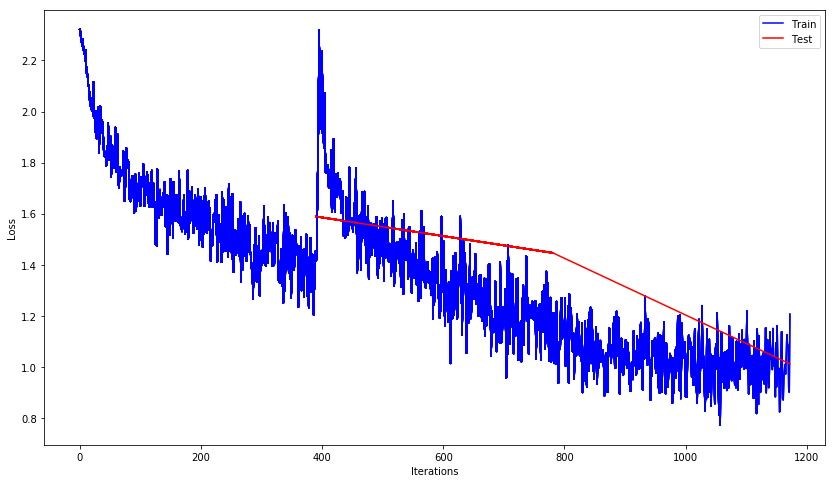

In [6]:
model = ResNeXt().cuda()
optimiser = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, nesterov=True, weight_decay=1e-4)
scheduler = optim.lr_scheduler.LambdaLR(optimiser, lr_lambda=lambda epoch: 5 if epoch == 1 else 1)
train_losses, test_losses, test_acc = [], [], 0
epochs, iters_per_epoch = 3, len(train_loader)

plt.figure(figsize=(14, 8))
plt.xlabel('Iterations')
plt.ylabel('Loss')
plotted_legend = False

def plot():
    global plotted_legend
    plt.plot(range(len(train_losses)), train_losses, 'b-', label='Train')
    plt.plot([(i + 1) * iters_per_epoch - 1 for i in range(len(test_losses))], test_losses, 'r-', label='Test')
    clear_output(wait=True)
    display(plt.gcf())
    if not plotted_legend:
        plt.legend(loc='upper right')
        plotted_legend = True

def train():
    model.train()
    for i, (x, y) in enumerate(train_loader):
        optimiser.zero_grad()
        y_hat = model(x.cuda())
        loss = F.cross_entropy(y_hat, y.cuda())
        loss.backward()
        train_losses.append(loss.item())
        optimiser.step()
        if i % 10 == 0:
            plot()

def test():
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            y_hat = model(x.cuda())
            test_loss += F.cross_entropy(y_hat, y.cuda(), reduction='sum').item()
            pred = y_hat.argmax(1, keepdim=True).cpu()
            correct += pred.eq(y.view_as(pred)).sum().item()

    test_losses.append(test_loss / len(test_data))
    return correct / len(test_data)

for _ in range(epochs):
    scheduler.step()
    train()
    test_acc = test()
plot()
clear_output(wait=True)
display('Final test accuracy: %.2f%%' % (test_acc * 100))